## Libraries

In [1]:
from google.colab import files, drive
import os
import shutil
from PIL import Image
import sys
import glob
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, RandomFlip, RandomRotation, RandomBrightness, Rescaling
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Softmax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
!pip install keras_tuner
import keras_tuner as kt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 10.6 MB/s eta 0:00:00


In [4]:
# Delete Unzipped Unempty Directory containing Dataset
# Uncommend Code in case of need (e.g., need intact unzipped dataset)
# shutil.rmtree("./Plants_2")

## Global Variables

In [5]:
# Choose Source of Dataset
DATASET_FROM_SCRATCH = False

# IF True: download, unzip, resize dataset from scratch
# Estimated time on free Colab instance is 20 mins

# IF False: download a saved previously preprocess dataset

In [6]:
# Paths as Folder Structure
paths = ["Plants_2/train", "Plants_2/valid", "Plants_2/test"]
paths = [os.path.join(os.getcwd(), path) for path in paths]

In [7]:
PATH_KEYWORD = 'diseased'
RESIZE_PIXELS = 512

In [8]:
IMG_SIZE = 256 # Assumed Square Image IMG_SIZE x IMG_SIZE
SEED = 101

In [9]:
MAX_TRIALS_TUNER = 10
EPOCHS_TUNER = 10

In [10]:
EPOCHS_FIT = 100

## Functions

In [11]:
# Function to Delete Subdirectories Selectively
def del_subdirs(path, keyword):
  paths_to_delete = [sd for sd in os.listdir(path) if keyword in sd]
  for p2d in paths_to_delete:
    shutil.rmtree(os.path.join(path, p2d))
  return

In [12]:
# Function to Resize Images
def resize_images(size_pixels):
  i = 0
  for path_subdir in paths:
    for img_path in glob.iglob(path_subdir + '/*/*.JPG', recursive=True):
        img = Image.open(img_path)
        img_resized = img.resize((size_pixels, size_pixels), Image.NEAREST)
        img_path_resized = img_path[:-4] + " _resized" + img_path[-4:]
        img_resized.save(img_path_resized, 'JPEG', quality=90)
        os.remove(img_path)
        clear_output(wait=True)
        i += 1
        display('Images resized: ' + str(i))

In [13]:
# Function to Build Deep Learning Model
def make_model(params):
  # Hyperparameters Search Space
  DROPOUT_CONV = params.Float("dropout_conv", min_value = 0.1, max_value = 0.5, step = 0.1)
  DROPOUT_DENSE = params.Float("dropout_dense", min_value = 0.1, max_value = 0.5, step = 0.1)

  FILTERS_1 = params.Choice("filters_1", values = [16, 32, 48])
  FILTERS_2 = params.Choice("filters_2", values = [32, 48, 64])
  FILTERS_3 = params.Choice("filters_3", values = [48, 64, 96])

  UNITS_DENSE = params.Choice("units_dense", values = [16, 32, 48, 64])
  OPTIMIZER = params.Choice("optimizer", values = ["adam", "sgd"])

  # Build Model
  model = Sequential(
      [
          Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
          RandomFlip("horizontal"),
          RandomRotation(0.2),
          RandomBrightness(0.2),
          Rescaling(scale=1/127.5, offset=-1),
          Conv2D(filters=FILTERS_1, kernel_size=3, padding="same", activation="relu"),
          MaxPooling2D(),
          Dropout(DROPOUT_CONV),
          Conv2D(filters=FILTERS_2, kernel_size=3, padding="same", activation="relu"),
          MaxPooling2D(),
          Dropout(DROPOUT_CONV),
          Conv2D(filters=FILTERS_3, kernel_size=3, padding="same", activation="relu"),
          MaxPooling2D(),
          Dropout(DROPOUT_CONV),
          Flatten(),
          Dense(UNITS_DENSE),
          Dropout(DROPOUT_DENSE),
          Dense(NUM_CLASSES),
          Softmax()
      ]
  )

  # Compile Model
  model.compile(optimizer=OPTIMIZER, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

  return model


## Dataset

In [14]:
# Mount Google Drive
# Required either way to save to OR read from the processed dataset
# Requires user permission
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
# Prepare Dataset
if DATASET_FROM_SCRATCH:
  # Download Original Dataset and Perform All Preprocessing from Scratch
  print("SELECTED OPTION: Use Original Dataset")
  print("The original dataset approx 8 GB will be downloaded and processed")
  print("This procedure could take about 20 mins on a free Colab instance.")
  print("-----------------------------------------------------------------")

  # Upload Kaggle Credentials JSON File
  print("STEP 1: Upload Kaggle JSON Credintials")
  kaggle_token = files.upload()

  # Set Kaggle Directory Variable to Locate Kaggle Credentials
  os.environ['KAGGLE_CONFIG_DIR'] = os.getcwd()

  # Download Kaggle Dataset
  print("STEP 2: Download Dataset")
  !kaggle datasets download -d csafrit2/plant-leaves-for-image-classification

  # Unzip Dataset
  print("STEP 3: Unzip Dataset")
  !unzip -q /content/plant-leaves-for-image-classification.zip

  # Delete Diseased Images
  print("STEP 4: Delete Certain Subdirectories")
  for path in paths:
    del_subdirs(path, PATH_KEYWORD)

  # Resize Images
  print("STEP 5: Resize Images")
  resize_images(RESIZE_PIXELS)

  # ZIP Processed Dataset
  print("STEP 6: Zip Processed Dataset")
  !zip -r -q /content/Plants_2.zip /content/Plants_2

  print("STEP 7: Save Processed Dataset to Drive")
  shutil.copy("/content/Plants_2.zip","/content/drive/MyDrive/")

else:
  # Use Previously Preprocessed Dataset, to save time
  print("SELECTED OPTION: Use Previously Preprocessed Dataset")
  !unzip -q /content/drive/MyDrive/Plants_2.zip -d /

SELECTED OPTION: Use Previously Preprocessed Dataset


## Model

In [16]:
train_ds = image_dataset_from_directory(paths[0], image_size=(IMG_SIZE, IMG_SIZE)) # Default Batch Size: 32
val_ds = image_dataset_from_directory(paths[1], image_size=(IMG_SIZE, IMG_SIZE))
test_ds = image_dataset_from_directory(paths[2], image_size=(IMG_SIZE, IMG_SIZE))

Found 2163 files belonging to 11 classes.
Found 55 files belonging to 11 classes.
Found 55 files belonging to 11 classes.


In [17]:
NUM_CLASSES = len(train_ds.class_names)

In [18]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(512).cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
tuner = kt.RandomSearch(make_model, objective = "val_accuracy", max_trials = MAX_TRIALS_TUNER, directory = "grid_search")
tuner.search(train_ds, validation_data = val_ds, epochs = EPOCHS_TUNER)

Trial 10 Complete [00h 00m 51s]
val_accuracy: 0.290909081697464

Best val_accuracy So Far: 0.6909090876579285
Total elapsed time: 00h 13m 00s


In [20]:
tuner.results_summary()

Results summary
Results in grid_search/untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 04 summary
Hyperparameters:
dropout_conv: 0.2
dropout_dense: 0.30000000000000004
filters_1: 32
filters_2: 48
filters_3: 48
units_dense: 16
optimizer: adam
Score: 0.6909090876579285

Trial 05 summary
Hyperparameters:
dropout_conv: 0.5
dropout_dense: 0.4
filters_1: 48
filters_2: 32
filters_3: 48
units_dense: 64
optimizer: adam
Score: 0.6363636255264282

Trial 07 summary
Hyperparameters:
dropout_conv: 0.2
dropout_dense: 0.5
filters_1: 32
filters_2: 32
filters_3: 48
units_dense: 64
optimizer: adam
Score: 0.6000000238418579

Trial 00 summary
Hyperparameters:
dropout_conv: 0.1
dropout_dense: 0.5
filters_1: 16
filters_2: 32
filters_3: 96
units_dense: 16
optimizer: sgd
Score: 0.5272727012634277

Trial 08 summary
Hyperparameters:
dropout_conv: 0.30000000000000004
dropout_dense: 0.30000000000000004
filters_1: 48
filters_2: 48
filters_3: 64
units_dense: 64
optimize

In [21]:
best_params = tuner.get_best_hyperparameters()[0]
best_params.get_config()

{'space': [{'class_name': 'Float',
   'config': {'name': 'dropout_conv',
    'default': 0.1,
    'conditions': [],
    'min_value': 0.1,
    'max_value': 0.5,
    'step': 0.1,
    'sampling': 'linear'}},
  {'class_name': 'Float',
   'config': {'name': 'dropout_dense',
    'default': 0.1,
    'conditions': [],
    'min_value': 0.1,
    'max_value': 0.5,
    'step': 0.1,
    'sampling': 'linear'}},
  {'class_name': 'Choice',
   'config': {'name': 'filters_1',
    'default': 16,
    'conditions': [],
    'values': [16, 32, 48],
    'ordered': True}},
  {'class_name': 'Choice',
   'config': {'name': 'filters_2',
    'default': 32,
    'conditions': [],
    'values': [32, 48, 64],
    'ordered': True}},
  {'class_name': 'Choice',
   'config': {'name': 'filters_3',
    'default': 48,
    'conditions': [],
    'values': [48, 64, 96],
    'ordered': True}},
  {'class_name': 'Choice',
   'config': {'name': 'units_dense',
    'default': 16,
    'conditions': [],
    'values': [16, 32, 48, 64],
 

In [22]:
model = tuner.hypermodel.build(best_params)

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 256, 256, 3)      0         
 tation)                                                         
                                                                 
 random_brightness_1 (Random  (None, 256, 256, 3)      0         
 Brightness)                                                     
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 32)    

In [24]:
earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, start_from_epoch=50)

In [25]:
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_FIT, callbacks=[earlystop])


Epoch 1/100
68/68 [==============================] - 9s 107ms/step - loss: 2.6605 - accuracy: 0.1854 - val_loss: 2.1601 - val_accuracy: 0.2182
Epoch 2/100
68/68 [==============================] - 7s 103ms/step - loss: 2.0008 - accuracy: 0.3079 - val_loss: 1.8086 - val_accuracy: 0.3818
Epoch 3/100
68/68 [==============================] - 7s 104ms/step - loss: 1.8199 - accuracy: 0.3726 - val_loss: 1.6171 - val_accuracy: 0.4364
Epoch 4/100
68/68 [==============================] - 7s 102ms/step - loss: 1.7006 - accuracy: 0.4202 - val_loss: 1.4514 - val_accuracy: 0.4727
Epoch 5/100
68/68 [==============================] - 7s 105ms/step - loss: 1.5828 - accuracy: 0.4387 - val_loss: 1.3861 - val_accuracy: 0.6000
Epoch 6/100
68/68 [==============================] - 7s 101ms/step - loss: 1.5495 - accuracy: 0.4757 - val_loss: 1.3468 - val_accuracy: 0.6000
Epoch 7/100
68/68 [==============================] - 7s 100ms/step - loss: 1.4802 - accuracy: 0.5035 - val_loss: 1.2484 - val_accuracy: 0.5636

In [26]:
results = model.evaluate(test_ds)
print("Loss: "+str(results[0])+" Accuracy: " + str(results[1]))

2/2 [==============================] - 0s 27ms/step - loss: 0.0755 - accuracy: 0.9818
Loss: 0.07552292197942734 Accuracy: 0.9818181991577148


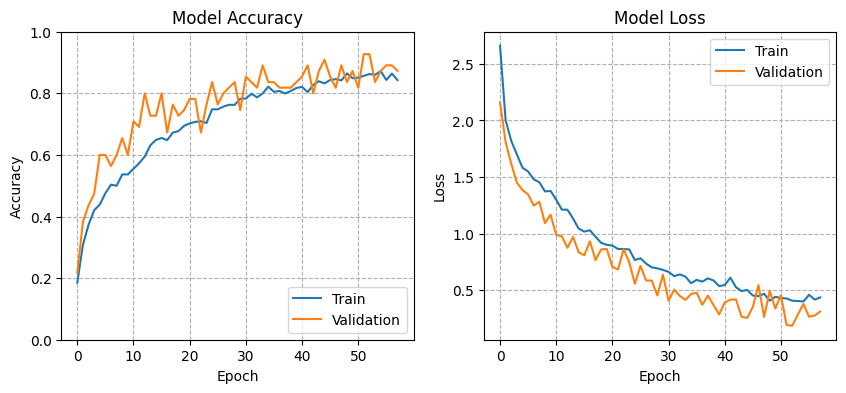

In [28]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.ylim(0,1)
plt.grid(True, "both", linestyle="--")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1,2,2)
plt.grid(True, "both", linestyle="--")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()

In [29]:
model.save("amd_cnn_model")

In [31]:
# Save Model to Google Drive
!zip -r -q /content/amd_cnn_model.zip /content/amd_cnn_model
# shutil.copy("/content/amd_cnn_model.zip","/content/drive/MyDrive/")


'/content/drive/MyDrive/amd_cnn_model.zip'